# Analyses post scrapping

Objectifs :
- on veut surveiller le nombre de concurrents
- ceux qui arrivent à vendre
- ceux qui changent de stratégie

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import datetime

In [2]:
villes = ['Arcueil', 'Bourg-la-Reine', 'Cachan']
df = pickle.load(open('tous_les_logements.p', 'rb')).drop('texte', axis=1)
df = df[df.ville.isin(villes)].copy()

print(df.shape)
df.tail(2)

(283, 11)


,date_enregistrement,type,ville,description,prix,note,nb_avis,nb_lits,nb_chambres,est_professionnel,est_nouveau
451,2024-01-13,Appartement,Cachan,"Logement 80m2,parking gratuit,Paris 5min envoi...",1096,4.47,51.0,4.0,2.0,False,False
454,2024-01-13,Appartement,Cachan,"Appartement 86m2, 6p, 3km Paris",526,NaN,NaN,5.0,3.0,False,False


In [3]:
# Nombre de concurrents
df.groupby(['date_enregistrement', 'ville']).date_enregistrement.count().to_frame().unstack().T

date_enregistrement                 2023-12-20  2023-12-25  2024-01-06  \
                    ville                                                
date_enregistrement Arcueil                  9          21          17   
                    Bourg-la-Reine           8          11           7   
                    Cachan                  46          47          53   

date_enregistrement                 2024-01-13  
                    ville                       
date_enregistrement Arcueil                  6  
                    Bourg-la-Reine           6  
                    Cachan                  52

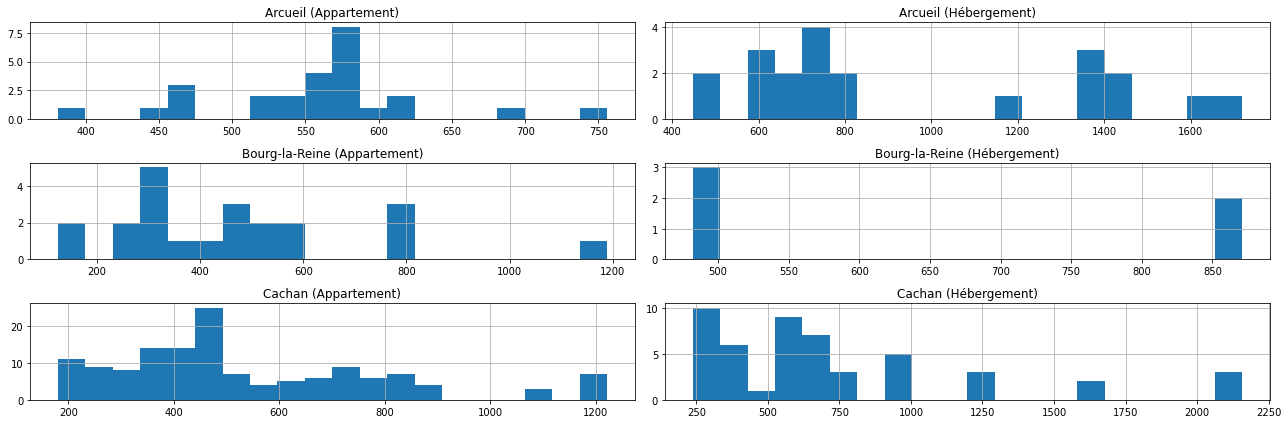

In [4]:
fig = plt.figure(figsize=(18, 6))
num_plot = 1
for ville in villes:
    vue = df[df.ville == ville]
    for type_ in ('Appartement', 'Hébergement'):
        fig.add_subplot(len(villes), 2, num_plot)
        plt.title(f'{ville} ({type_})')
        vue[vue.type == type_].prix.hist(bins=20)
        num_plot += 1
plt.tight_layout()

In [5]:
# Être nouveau augmente les prix
df.groupby('est_nouveau').prix.mean()

est_nouveau
False    597.565022
True     670.733333
Name: prix, dtype: float64

In [6]:
# Être professionnel aussi
df.groupby('est_professionnel').prix.mean()

est_professionnel
False    600.898374
True     694.054054
Name: prix, dtype: float64

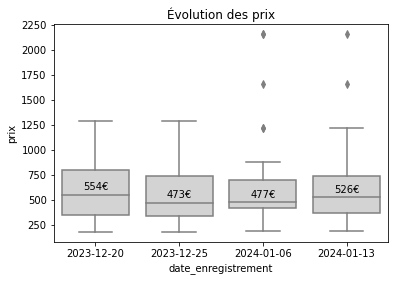

In [7]:
# Comment évoluent les prix ?
import seaborn as sns
vue = df[df.ville == 'Cachan']


sns.boxplot(x=vue.date_enregistrement, y=vue.prix, color='lightgray')
médianes = vue.groupby('date_enregistrement').prix.median()
for i, médiane in enumerate(médianes):
    plt.text(i, médiane + 50, f'{médiane:.0f}€', ha='center')
plt.title('Évolution des prix');

## Suivi des logements dans le temps

In [8]:
df.sample(3)

,date_enregistrement,type,ville,description,prix,note,nb_avis,nb_lits,nb_chambres,est_professionnel,est_nouveau
358,2024-01-13,Appartement,Cachan,"Appartement 86m2, 6p, 3km Paris",526,NaN,NaN,5.0,3.0,False,True
185,2023-12-25,Hébergement,Arcueil,Maison cosy et jardin Paris sud,708,4.90,21.0,NaN,NaN,False,False
119,2023-12-25,Appartement,Arcueil,★THE COSY★ TERRASSE ★ AUX PORTES DE PARIS,474,4.86,74.0,NaN,NaN,True,False


In [9]:
clé = ['type', 'ville', 'description']

In [10]:
vue = df[['date_enregistrement'] + clé + ['prix']].drop_duplicates()
gb = vue.groupby(clé).prix.apply(list).apply(pd.Series)
dates = list(map(lambda d: d.strftime('%Y-%m-%d'), vue.date_enregistrement.unique()))
gb.columns = dates
gb

2023-12-20  \
type            ville          description                                                      
Appartement     Arcueil        Appartement Cocon avec parking privé près de Paris       690.0   
                               Appartement duplex - Arcueil                             565.0   
                               Beau T3 à Arcueil à 3 min RER B « Laplace »              573.0   
                               Home sweet home in Paris                                 579.0   
                               L'Essentiel : Appartement lumineux proche de tout        381.0   
...                                                                                       ...   
Maison de ville Arcueil        Arcueil House (maison de ville)                          611.0   
                Bourg-la-Reine Maison de ville avec jardin                              342.0   
                Cachan         La Maison du Figuier-Direct StadeDeFrance/Airports       728.0   
Villa           Cachan         Jardin fleuri tout près de Paris                         916.0   
                               Maison et jardin boisé A 10 minutes de Paris !           805.0   

                                                                                   2023-12-25  \
type            ville          description                                                      
Appartement     Arcueil        Appartement Cocon avec parking privé près de Paris       558.0   
                               Appartement duplex - Arcueil                             565.0   
                               Beau T3 à Arcueil à 3 min RER B « Laplace »              447.0   
                               Home sweet home in Paris                                 579.0   
                               L'Essentiel : Appartement lumineux proche de tout          NaN   
...                                                                                       ...   
Maison de ville Arcueil        Arcueil House (maison de ville)                            NaN   
                Bourg-la-Reine Maison de ville avec jardin                              342.0   
                Cachan         La Maison du Figuier-Direct StadeDeFrance/Airports       728.0   
Villa           Cachan         Jardin fleuri tout près de Paris                         916.0   
                               Maison et jardin boisé A 10 minutes de Paris !             NaN   

                                                                                   2024-01-06  \
type            ville          description                                                      
Appartement     Arcueil        Appartement Cocon avec parking privé près de Paris         NaN   
                               Appartement duplex - Arcueil                             597.0   
                               Beau T3 à Arcueil à 3 min RER B « Laplace »                NaN   
                               Home sweet home in Paris                                   NaN   
                               L'Essentiel : Appartement lumineux proche de tout          NaN   
...                                                                                       ...   
Maison de ville Arcueil        Arcueil House (maison de ville)                            NaN   
                Bourg-la-Reine Maison de ville avec jardin                                NaN   
                Cachan         La Maison du Figuier-Direct StadeDeFrance/Airports         NaN   
Villa           Cachan         Jardin fleuri tout près de Paris                         831.0   
                               Maison et jardin boisé A 10 minutes de Paris !             NaN   

                                                                                   2024-01-13  
type            ville          description                                                     
Appartement     Arcueil        Appartement Cocon avec parking privé près de Paris         NaN  
         

In [33]:
# Ceux qui ont l'air d'avoir loué
# (ils n'apparaissent plus depuis au moins deux scrapings)
nb = 2
last_cols = gb.columns[-nb:].tolist()
cond = gb[last_cols].isnull().sum(axis=1) == nb
loués = gb[cond].reset_index()
pd.merge(
    loués[loués.ville == 'Cachan'],
    df[clé + ['nb_chambres']],
    on=clé, how='inner'
)

,type,ville,description,2023-12-20,2023-12-25,2024-01-06,2024-01-13,nb_chambres
0,Appartement,Cachan,Appartement 6 invités à 25 min du centre de Paris,473.0,473.0,NaN,NaN,NaN
1,Appartement,Cachan,Appartement 6 invités à 25 min du centre de Paris,473.0,473.0,NaN,NaN,NaN
2,Appartement,Cachan,Appartement 6 invités à 25 min du centre de Paris,473.0,473.0,NaN,NaN,NaN
3,Appartement,Cachan,Appartement lumineux,750.0,782.0,NaN,NaN,NaN
4,Appartement,Cachan,Appartement lumineux,750.0,782.0,NaN,NaN,3.0
5,Appartement,Cachan,"Apt 45m² 2 chb calme, 50m RER B, 15 min PARIS ...",456.0,456.0,NaN,NaN,2.0
6,Appartement,Cachan,"Apt 45m² 2 chb calme, 50m RER B, 15 min PARIS ...",456.0,456.0,NaN,NaN,2.0
7,Appartement,Cachan,"Apt 45m² 2 chb calme, 50m RER B, 15 min PARIS ...",456.0,456.0,NaN,NaN,2.0
8,Appartement,Cachan,Charmant appartement 3 pièces,248.0,NaN,NaN,NaN,NaN
9,Appartement,Cachan,Design Original - Appart'Hôtel Mont Blanc,666.0,NaN,NaN,NaN,NaN


In [27]:
# Parmi ceux qui ont loué, combien avaient concédé à une baisse de prix ?
(loués.nunique(axis=1) > 1).sum() /  len(loués)

0.12280701754385964

In [29]:
# Ceux qui changent de stratégie :
changeurs = gb[gb.nunique(axis=1) > 1].reset_index()
changeurs[changeurs.ville == 'Cachan']

,type,ville,description,2023-12-20,2023-12-25,2024-01-06,2024-01-13
7,Appartement,Cachan,2P a 10 min à pied du RER B,389.0,380.0,395.0,385.0
8,Appartement,Cachan,Appartement - 2 pièces + Salon,1190.0,1190.0,1222.0,1222.0
9,Appartement,Cachan,"Appartement 86m2, 6p, 3km Paris",494.0,494.0,526.0,526.0
10,Appartement,Cachan,Appartement La Maison Blanche,185.0,185.0,200.0,NaN
11,Appartement,Cachan,Appartement Loft atypique avec terrasse,670.0,670.0,702.0,702.0
12,Appartement,Cachan,Appartement entier calme pour JO 2024,472.0,504.0,474.0,NaN
13,Appartement,Cachan,Appartement lumineux,750.0,782.0,NaN,NaN
14,Appartement,Cachan,Appartement lumineux à 5 min à pied du RER B,389.0,389.0,420.0,420.0
15,Appartement,Cachan,"Appartement proche Paris, commerces et transports",315.0,315.0,340.0,340.0
16,Appartement,Cachan,Appartement très calme.,459.0,459.0,449.0,428.0


In [ ]:
# Ceux qui ont vendu :
TODO

## Annexes

In [122]:
# Recherche d'une clé primaire : 
variables_dynamiques = ['date_enregistrement', 'est_nouveau', 'note', 'nb_avis']
vue = df.drop(variables_dynamiques, axis=1).drop_duplicates()
vue[vue[clé].duplicated(keep=False)]

# --> les logements qui apparaissent sont ceux qui ont changé de stratégie de prix !
# --> la clé ['ville', 'type', 'description'] identifie donc un logement de façon unique

,type,ville,description,prix,nb_lits,nb_chambres,est_professionnel
41,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1425,NaN,NaN,False
57,Appartement,Cachan,2P a 10 min à pied du RER B,389,NaN,NaN,False
197,Appartement,Cachan,2P a 10 min à pied du RER B,380,NaN,NaN,False
239,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1355,NaN,NaN,False
